# 最適フィードバック制御モデル (optimal feedback control; OFC)

## 最適フィードバック制御モデルの構造
> Todorov, E. (2005) Stochastic optimal control and estimation methods adapted to the noise characteristics of the sensorimotor system. *Neural Computation* 17(5): 1084-1108

本節はTodorovの[MATLABコード](https://homes.cs.washington.edu/~todorov/software/gLQG.zip)を元にしている (現状ほぼJuliaへの単なる移植であることを明言しておく)．

**最適フィードバック制御モデル(optimal feedback control; OFC)** の特徴として目標軌道を必要としないことが挙げられる．**Kalman フィルタ**による状態推定と**線形2次レギュレーター(LQR: linear-quadratic regurator)** により推定された状態に基づいて運動指令を生成という2つの流れが基本となる．ここで考える制御問題は**線形2次ガウシアン(LQG: linear-quadratic-Gaussian)制御**と呼ばれる．



### 系の状態変化

$$
\begin{aligned}
&\text {Dynamics} \quad \mathbf{x}_{t+1}=A \mathbf{x}_{t}+B \mathbf{u}_{t}+\boldsymbol{\xi}_{t}+\sum_{i=1}^{c} \varepsilon_{t}^{i} C_{i} \mathbf{u}_{t}\\
&\text {Feedback} \quad \mathbf{y}_{t}=H \mathbf{x}_{t}+\omega_{t}+\sum_{i=1}^{d} \epsilon_{t}^{i} D_{i} \mathbf{x}_{t}\\
&\text{Cost per step}\quad \mathbf{x}_{t}^{T} Q_{t} \mathbf{x}_{t}+\mathbf{u}_{t}^{T} R \mathbf{u}_{t}
\end{aligned}
$$

### 運動制御 (Linear-Quadratic Regulator)

$$
\begin{align}
\mathbf{u}_{t}&=-L_{t} \widehat{\mathbf{x}}_{t}\\
L_{t}&=\left(R+B^{\top} S_{t+1} B\right)^{-1} B^{\top} S_{t+1} A\\
S_{t}&=Q_{t}+A^{\top} S_{t+1}\left(A-B L_{t}\right)\\
\end{align}
$$

### 状態推定 (Kalman Filter)

$$
\begin{align}
\widehat{\mathbf{x}}_{t+1}&=A \widehat{\mathbf{x}}_{t}+B \mathbf{u}_{t}+K_{t}\left(\mathbf{y}_{t}-H \widehat{\mathbf{x}}_{t}\right)+\boldsymbol{\eta}_{t} \\ 
K_{t}&=A \Sigma_{t} H^{\top}\left(H \Sigma_{t} H^{\top}+\Omega^{\omega}\right)^{-1} \\ 
\Sigma_{t+1}&=\Omega^{\xi}+\left(A-K_{t} H\right) \Sigma_{t} A^{\top}
\end{align}
$$

$K$はカルマンゲイン(Kalman gains)，$L$はフィードバックゲイン(feedback gains)である．$K, L$は時間に依存する行列であることに注意しよう．実装上は$\boldsymbol{\xi}_{t}=$ `C0 * randn`，$\omega_{t}=$ `D0 * randn`，$\boldsymbol{\eta}_{t}=$ `E0 * randn`

## 最適フィードバック制御モデルの実装

ライブラリの読み込み．

In [1]:
using LinearAlgebra, Kronecker, Random, BlockDiagonals, PyPlot
rc("axes.spines", top=false, right=false)

eye(T::Type, n) = Diagonal{T}(I, n)
eye(n) = eye(Float64, n)

eye (generic function with 2 methods)

### 前処理
一部のスカラーをベクトルに変換する．

In [2]:
function convertScalar2Vec!(C, D, C0, D0, E0)
    szX = size(A,1);
    szU = size(B,2);
    szY = size(H,1);
    
    # if C or D are scalar, replicate them into vectors
    if size(C,1)==1 #&& szU>1
       C = C*ones(szU,1)
    end

    if length(D)==1
        if D[1]==0
            D = zeros(szY, szX)
        else
            D = D*ones(szX,1)
            if szX != szY
                error("D can only be a scalar when szX = szY")
            end
        end
    end

    # if C0,D0,E0 are scalar, set them to 0 matrices and adjust size
    if length(C0)==1 && C0[1]==0
        C0 = zeros(szX,1)
    end
    if length(D0)==1 && D0[1]==0
        D0 = zeros(szY,1)
    end
    if length(E0)==1 && E0[1]==0
        E0 = zeros(szX,1);
    end
    return C, D, C0, D0, E0
end

convertScalar2Vec! (generic function with 1 method)

### gLQG

メインとなるgeneralized LQGの関数．カルマンゲイン$K$とフィードバックゲイン$L$を学習する．

In [3]:
function gLQG(A, B, C, C0, H, D, D0, E0, Q, R, X1, S1; Init=1, Niter=0, MaxIter=500, Eps=10^-8)
    """
    - Init : 0 - open loop; 1 (default) - LQG; 2 - random  (optional)
    - Niter : iterations; 0 (default) - until convergence   (optional)

    - K : Filter gains
    - L : Control gains
    - Cost : Expected cost (per iteration)
    """
    # determine sizes
    szX = size(A,1);
    szU = size(B,2);
    szY = size(H,1);
    szC = size(C,3);
    szC0 = size(C0,2);
    szD = size(D,3);
    szD0 = size(D0,2);
    szE0 = size(E0,2);
    N = size(Q,3);
    
    # initialize policy and filter
    K = zeros(szX,szY,N-1) # Filter gains
    L = zeros(szU,szX,N-1) # Control gains

    Cost = zeros(MaxIter)
    for iter = 1:MaxIter
        # initialize covariances
        SiE = S1
        SiX = X1 * X1'
        SiXE = zeros(szX,szX)

        for k = 1:N-1
            # compute Kalman gain
            temp = SiE + SiX + SiXE + SiXE'

            if size(D,2)==1
                DSiD = Diagonal((diag(temp).*D.^2)[:, 1])
            else
                DSiD = zeros(szY,szY);
                for i=1:szD
                    DSiD += D[:,:,i] * temp * D[:,:,i]'
                end
            end

            K[:,:,k] = A * SiE * H' * pinv(H * SiE * H' + D0 * D0' + DSiD)

            # compute new SiE
            newE = E0 * E0' + C0 * C0' + (A - K[:,:,k] * H) * SiE * A'
            LSiL = L[:,:,k] * SiX * L[:,:,k]'

            if size(C,2)==1
                newE += B * Diagonal(diag(LSiL) .* C.^2) * B'
            else
                for i=1:szC
                    newE += B*C[:,:,i] * LSiL * C[:,:,i]'*B'
                end
            end

            # update SiX, SiE, SiXE
            AmBL = A - B * L[:,:,k]
            SiX = E0 * E0' + K[:,:,k] * H * SiE * A' + AmBL * SiX * AmBL' + AmBL * SiXE * H' * K[:,:,k]' + K[:,:,k] * H * SiXE' * AmBL'
            SiE = newE
            SiXE = AmBL * SiXE * (A - K[:,:,k]*H)' - E0 * E0'
        end

        # first pass initialization
        if iter==1
            if Init==0         # open loop
                K = zeros(szX,szY,N-1)
            elseif Init==2     # random
                K = randn(szX,szY,N-1)
            end
        end

        # initialize optimal cost-to-go function
        Sx = Q[:,:,N]
        Se = zeros(szX,szX)
        Cost[iter] = 0

        # backward pass - recompute control policy
        for k=N-1:-1:1
            # update Cost
            Kk = K[:,:,k]
            Cost[iter] = Cost[iter] + tr(Sx*C0*C0') + tr(Se * (Kk * D0 * D0' * Kk' + E0 * E0' + C0 * C0'))

            # Controller
            temp = R .+ B' * Sx * B
            BSxeB = B' * (Sx + Se) * B

            if size(C,2)==1
                temp += Diagonal(diag(BSxeB).*C.^2)
            else
                for i=1:size(C,3)
                    temp += C[:,:,i]' * BSxeB * C[:,:,i]
                end
            end

            L[:,:,k] = pinv(temp)*B'*Sx*A;
            Lk = L[:,:,k]

            # compute new Se
            newE = A' * Sx * B * Lk + (A - Kk * H)'*Se*(A - Kk * H);

            # update Sx and Se
            Sx = Q[:,:,k] + A' * Sx * (A - B * Lk);
            KSeK = Kk' * Se * Kk;
            if size(D,2)==1
                Sx += Diagonal(diag(KSeK).*D.^2)
            else
                for i=1:szD
                Sx += D[:,:,i]'*KSeK*D[:,:,i]
                end
            end    
            Se = newE;
        end

        # adjust cost
        Cost[iter] += (X1' * Sx * X1)[1] + tr((Se + Sx) * S1)
        # check convergence of Cost
        if iter > 1
            ΔCost = abs(Cost[iter-1]-Cost[iter])
            if (Niter>0 && iter>=Niter) || (Niter==0 && ΔCost < Eps)
                # print result
                if Cost[iter-1]!=Cost[iter]
                   println("Log10ΔCost = ", log10(ΔCost))
                else
                   println("ΔCost = 0")
                end

                break
            end
        end
    end
    return K, L, Cost
end

gLQG (generic function with 1 method)

### 理想的な軌跡の計算

学習したフィードバックゲインを用い，系の状態の予測が実際の状態と一致している場合の軌跡`Xa`を計算する．この場合，系の内部状態の正解が得られているのと同じなので，カルマンゲインは用いない．

In [4]:
function computeAverageTrajectory(A, B, X1, L, N)
    szX = size(A,1)
    Xa = zeros(szX,N)
    Xa[:,1] = X1

    for k=1:N-1
        u = -L[:,:,k] * Xa[:,k]
        Xa[:,k+1] = A * Xa[:,k] + B * u
    end
    return Xa
end

computeAverageTrajectory (generic function with 1 method)

### ノイズを含む軌跡のシミュレーション
`NSim`回のシミュレーションを並列で計算する．

In [5]:
# simulate noisy trajectories
function simulateNoisyTrajectories(A, B, C, C0, H, D, D0, E0, Q, R, X1,S1, L, K, NSim)
    """
    - NSim : number of simulated trajectories (default 0)  (optional)
    - XSim : Simulated trajectories
    - CostSim : Empirical cost
    """
    szX = size(A,1);
    szU = size(B,2);
    szY = size(H,1);
    szC0 = size(C0,2);
    szD = size(D,3);
    szD0 = size(D0,2);
    szE0 = size(E0,2);
    N = size(Q,3);

    # square root of S1
    u, s, v = svd(S1)
    sqrtS = u * sqrt(Diagonal(s)) * v'

    # initialize
    XSim = zeros(szX,NSim,N)
    Xhat = zeros(szX,NSim,N)
    Xhat[:,:,1] = repeat(X1, 1, NSim)
    XSim[:,:,1] = Xhat[:,:,1] + sqrtS * randn(szX,NSim);
    CostSim = 0
    # loop over N
    for k=1:N-1
        # update control and cost
        U = -L[:,:,k] * Xhat[:,:,k]
        CostSim += sum(sum(U.*(R*U))) + sum(sum(XSim[:,:,k].*(Q[:,:,k]*XSim[:,:,k])))

        # compute noisy control
        Un = copy(U)
        if size(C,2)==1
            Un += U .* randn(szU,NSim) .* repeat(C, 1, NSim)
        else
            for i=1:szC
                Un += (C[:,:,i]*U) .* repeat(randn(1,NSim), szU, 1)
            end
        end

        # compute noisy observation
        y = H*XSim[:,:,k] + D0 * randn(szD0,NSim)
        if size(D,2)==1
            y += XSim[:,:,k] .* randn(szY,NSim) .* repeat(D, 1, NSim)
        else
            for i=1:szD
                y += (D[:,:,i] * XSim[:,:,k]).*repeat(randn(1,NSim), szY, 1)
            end
        end

        XSim[:,:,k+1] = A*XSim[:,:,k] + B*Un + C0*randn(szC0,NSim);
        Xhat[:,:,k+1] = A*Xhat[:,:,k] + B*U + K[:,:,k] * (y - H * Xhat[:,:,k]) + E0*randn(szE0,NSim);
    end

    # final cost update
    CostSim += sum(sum(XSim[:,:,N].*(Q[:,:,N]*XSim[:,:,N])));
    CostSim /= NSim
    
    return XSim, CostSim
end

simulateNoisyTrajectories (generic function with 1 method)

### メイン関数
上記の関数をまとめた関数を記述する．

In [6]:
function kalman_lqg(A, B, C, C0, H, D, D0, E0, Q, R, X1, S1, NSim)
    C, D, C0, D0, E0 = convertScalar2Vec!(C, D, C0, D0, E0)
    K, L, Cost = gLQG(A, B, C, C0, H, D, D0, E0, Q, R, X1, S1)
    Xa = computeAverageTrajectory(A, B, X1, L, N)
    XSim, CostSim = simulateNoisyTrajectories(A, B, C, C0, H, D, D0, E0, Q, R, X1,S1, L, K, NSim)
    return K, L, Cost, Xa, XSim, CostSim
end

kalman_lqg (generic function with 1 method)

## シミュレーションの実行
`N`で到達時刻，`T`で目標位置を設定する．

In [7]:
dt = 0.01;        # time step (sec)
m = 1;            # mass (kg)
b = 0;            # damping (N/sec)
τ = 40;          # time constant (msec)
c = 0.5;          # control-dependent noise
r = 0.00001;      # control signal penalty
v = 0.2;          # endpoint velocity penalty
f = 0.02;         # endpoint force penalty
pos = 0.5*0.02;   # position noise
vel = 0.5*0.2;    # velocity noise
frc = 0.5*1.0;    # force noise

N = 40;               # duration in number of time steps
T = 0.5;              # target distance

dtt = dt/(τ/1000);

In [8]:
n = 4
NSim = 10;

系の状態を決定する定数，定行列を定義する．

In [9]:
A = Tridiagonal(zeros(n), [1.0, 1-dt*b/m, 1-dtt, 1-dtt, 1.0], [dt, dt/m, dtt, 0])
B = [zeros(3); dtt; 0][:,:]
C = c
C0 = 0
H = [eye(3) zeros(3, 2)]
D = 0
D0 = Diagonal([pos, vel, frc])
E0 = 0
R = r/N
d = Matrix([Diagonal([1.0, v, f]) zeros(3) [-1; zeros(2)]])
Q = zeros(n+1, n+1, N);
Q[:,:,N] = d'*d
X1 = [zeros(n); T][:,:]
S1 = zeros(n+1, n+1);

シミュレーションを実行する．

In [10]:
K, L, Cost, Xa, XSim, CostSim = kalman_lqg(A, B, C, C0, H, D, D0, E0, Q, R, X1, S1, NSim);

Log10ΔCost = -10.020441448217328

## 結果の描画

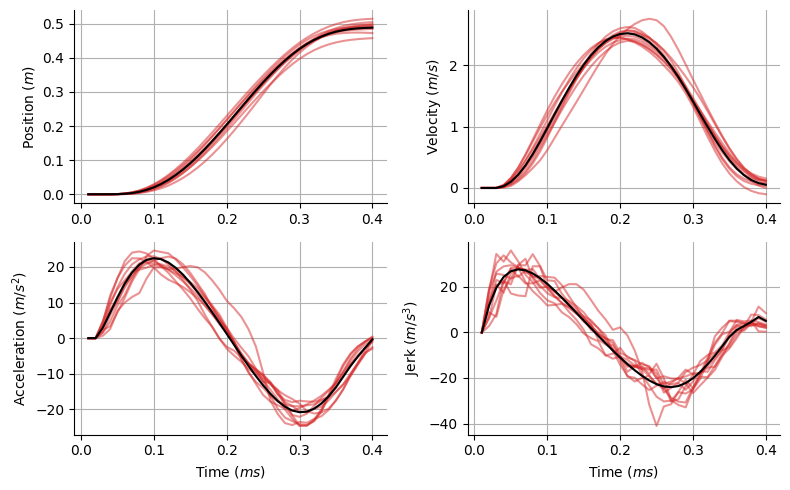

In [11]:
tarray = (1:N) * dt
label = [L"Position ($m$)", L"Velocity ($m/s$)", L"Acceleration ($m/s^2$)", L"Jerk ($m/s^3$)"]

figure(figsize=(8, 5))
for i in 1:4
    subplot(2,2,i)
    plot(tarray, XSim[i,:,:]', "tab:red", alpha=0.5)
    plot(tarray, Xa[i,:], "k")
    ylabel(label[i]); grid()
    if i >= 3
        xlabel(L"Time ($ms$)")
    end
end
tight_layout()